In [1]:
# import mne

from pathlib import Path

import mne
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.dataset_utils import build_manifest_simple, save_manifest

standardize = lambda x: (x - x.mean()) / x.std()

## 1. Load data

### 1.1 Load labels

In [2]:
manifest = pd.read_csv("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/manifest.csv")  
row = manifest.iloc[0]

In [ ]:
STAGE_MAP = {
    "w":"Wake", "wake":"Wake",
    "n":"NREM","nr":"NREM","nrem":"NREM",
    "r":"REM","rem":"REM"
}
ART = {"1","2","3"}  # make sure these truly mean artifacts in your files
PRIORITY = {"REM":3, "NREM":2, "Wake":1, "Unknown":0}

def norm_stage(x):
    x = str(x).strip().lower()
    return STAGE_MAP.get(x, "Unknown")

def is_artifact(a, b):
    return (str(a).strip() in ART) or (str(b).strip() in ART)

def consensus(a, b) -> str:
    a, b = norm_stage(a), norm_stage(b)
    if a == b:                     # match
        return a
    if a == "Unknown": return b    # prefer known
    if b == "Unknown": return a
    return a if PRIORITY[a] >= PRIORITY[b] else b

labels = pd.read_csv(row['scoring_path'], header=None,
                     names=["epoch","s1","s2"], sep=r"[;,]", engine="python")

labels["s1"] = labels["s1"].astype(str).str.strip()
labels["s2"] = labels["s2"].astype(str).str.strip()

labels["stage"]    = [consensus(a,b) for a,b in zip(labels["s1"], labels["s2"])]
labels["artifact"] = [is_artifact(a,b) for a,b in zip(labels["s1"], labels["s2"])]

In [4]:
labels.stage.value_counts()

stage
Wake       11059
NREM        8635
REM         1587
Unknown      319
Name: count, dtype: int64

In [5]:
mask = labels.stage == "Unknown"
labels[labels.stage == "Unknown"].head(10)

,epoch,s1,s2,stage,artifact
336,336,1,1,Unknown,True
337,337,1,1,Unknown,True
367,367,1,1,Unknown,True
679,679,1,1,Unknown,True
680,680,1,1,Unknown,True
681,681,1,1,Unknown,True
682,682,1,1,Unknown,True
1036,1036,1,1,Unknown,True
1397,1397,3,3,Unknown,True
2042,2042,2,2,Unknown,True


### 1.2 Load EEG-recording

In [6]:
import numpy as np, pandas as pd, mne

labels   = labels.copy()         # has columns 'stage', 'artifact'
stage_map = {'Wake':1, 'NREM':2, 'REM':3}

# --- Load & channel typing ---
raw = mne.io.read_raw_edf(row["edf_path"] , preload=True, verbose=False)
raw.rename_channels(lambda s: s.strip())
raw.set_channel_types({ch: "eeg" for ch in raw.ch_names if "EEG" in ch.upper()})
raw.set_channel_types({ch: "emg" for ch in raw.ch_names if "EMG" in ch.upper()})
raw.set_eeg_reference("average")

# --- Line noise + band-pass ---
mains = 50  # you're in Europe/Copenhagen
raw.notch_filter(freqs=[mains], picks="all")
raw.filter(l_freq=0.5, h_freq=45., picks="eeg")   # EEG
raw.filter(l_freq=10.,  h_freq=50., picks="emg") # EMG tone

# --- Sample-accurate 4-s epoching aligned to labels ---
sf   = raw.info["sfreq"]
spe  = int(round(4.0 * sf))       # samples per epoch
elen = spe / sf                   # exact epoch length
n_lab = len(labels)
n_fit = min(raw.n_times // spe, n_lab)

stop_sample = n_fit * spe
raw.crop(tmin=0.0, tmax=(stop_sample - 1)/sf)

# Fixed-length epochs; do NOT auto-drop (we’ll select by our mask)
epochs = mne.make_fixed_length_epochs(raw, duration=elen,
                                      preload=True, reject_by_annotation=False)

# Align labels and build masks
labels = labels.iloc[:len(epochs)].reset_index(drop=True)
good = labels["stage"].isin(stage_map) & (~labels["artifact"].astype(bool))

# --- Arrays for ML ---
picks = mne.pick_types(epochs.info, eeg=True, emg=True)
X = epochs.get_data(picks=picks)               # (N, C, T)
y = labels.loc[good, "stage"].map(stage_map).to_numpy()
X = X[good.to_numpy()]                         # keep only good epochs

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (1.320 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
21600 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21600 events and 512 original time points ...
0 bad epochs dropped


### 1.2 Access raw data

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>
128.0
['EEG1', 'EEG2', 'EMG']


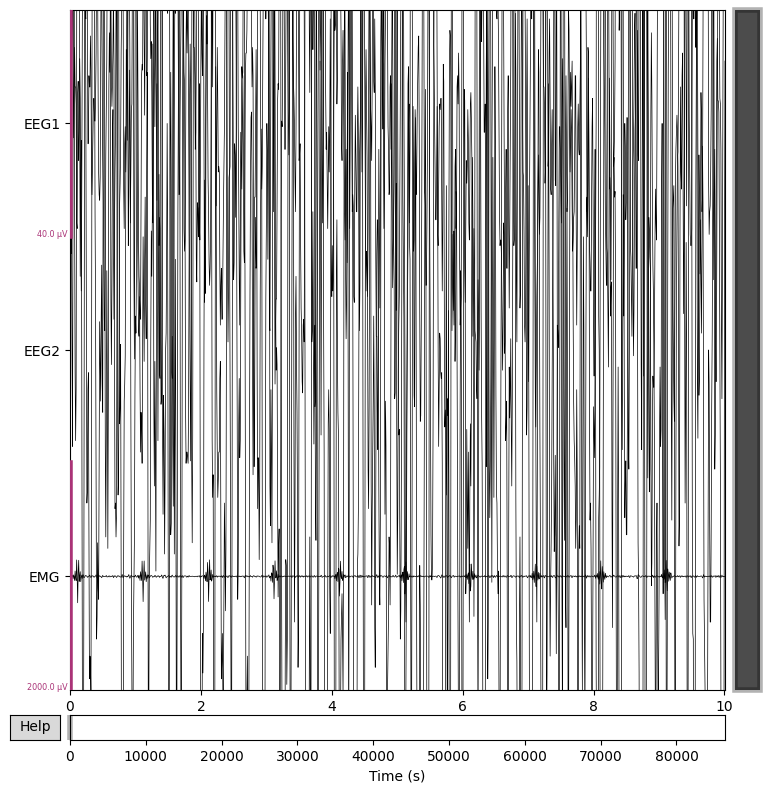

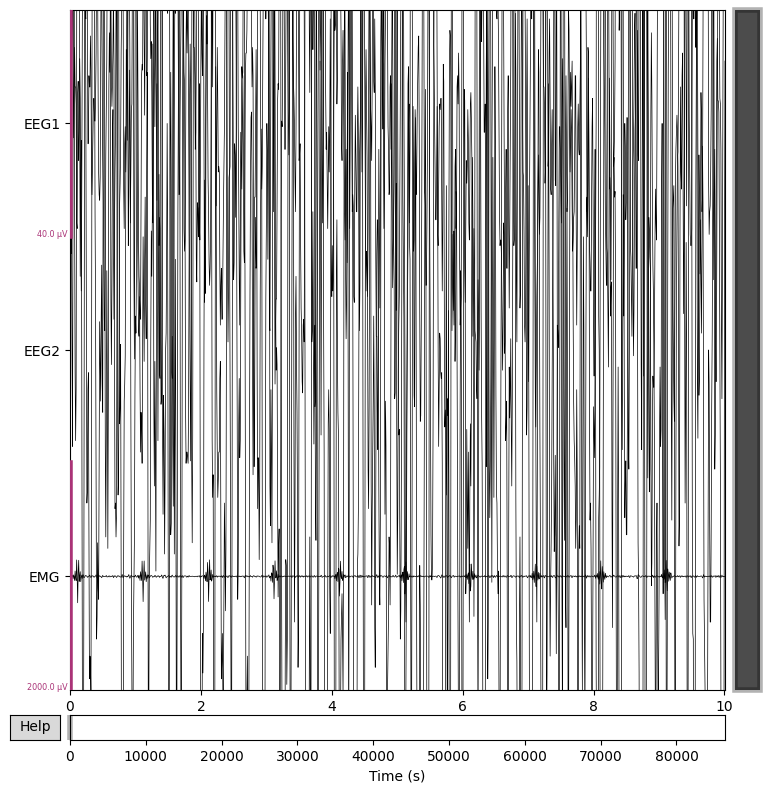

In [39]:
print(raw)              # summary (channels, sfreq, duration)
print(raw.info["sfreq"])  # sampling rate
print(raw.ch_names)     # channel names

# Get data arrays (Volts) — picks by type/name
eeg_data = raw.get_data(picks="eeg")        # shape (n_eeg_channels, n_samples)
emg_data = raw.get_data(picks="emg")        # shape (1, n_samples)

# Quick look (interactive browser)
raw.plot()  # uncomment in a notebook/script

### 1.2 Annotations

In [49]:
row

cohort                                                    CohortA
animal_id                                                      A1
edf_path        C:\Users\MDBI\Documents\public-datasets\sleepy...
scoring_path    C:\Users\MDBI\Documents\public-datasets\sleepy...
has_scoring                                                  True
Name: 0, dtype: object

,epoch,s1,s2,stage,artifact
0,0,n,n,NREM,False
1,1,n,n,NREM,False
2,2,n,n,NREM,False
3,3,n,n,NREM,False
4,4,n,n,NREM,False


In [ ]:
import mne, numpy as np, pandas as pd



Extracting EDF parameters from C:\Users\MDBI\Documents\public-datasets\sleepy-rat\CohortA\recordings\A1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Used Annotations descriptions: [np.str_('NREM'), np.str_('REM'), np.str_('Wake')]
Not setting metadata
19932 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19932 events and 513 original time points ...
1 bad epochs dropped


In [55]:
X.shape, y.shape

((19931, 3, 513), (19931,))

,epoch,s1,s2,stage,artifact
0,0,n,n,NREM,False
1,1,n,n,NREM,False
2,2,n,n,NREM,False
3,3,n,n,NREM,False
4,4,n,n,NREM,False


In [46]:
raw.times

array([0.00000000e+00, 7.81250000e-03, 1.56250000e-02, ...,
       8.63999766e+04, 8.63999844e+04, 8.63999922e+04])

In [47]:
raw.times[-1]

np.float64(86399.9921875)

In [ ]:
raw.annotationsa

<Annotations | 0 segments>

In [ ]:
ann = mne.Annotations(
    onset=0,      # seconds from recording start
    duration=4.0,
    description=sc["stage"].astype(str).to_numpy(),  # e.g., 'W','N1','N2','N3','R' or custom strings
)

raw.set_annotations(ann)

ValueError: Onset, duration, description, and ch_names must be equal in sizes, got 1, 1, 21600, and 1.

In [ ]:
import pandas as pd

hyp = pd.read_csv(".csv")  # your schema here
ann = mne.Annotations(
    onset=hyp["onset_sec"].to_numpy(),      # seconds from recording start
    duration=hyp["duration_sec"].to_numpy(),
    description=hyp["stage"].astype(str).to_numpy(),  # e.g., 'W','N1','N2','N3','R' or custom strings
)
raw.set_annotations(ann)


In [31]:
eeg_band = (0.5, 50)   # Hz
line_freq = 50.0       # set 60.0 if needed
raw_f = raw.copy()
raw_f.notch_filter([line_freq])
picks_eeg = mne.pick_types(raw_f.info, eeg=True, emg=False)
raw_f.filter(eeg_band[0], eeg_band[1], picks=picks_eeg)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edg

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>

In [23]:
# pick a short window, e.g., 2 minutes starting at 6.0 h
start_h, duration_h = 6.0, 0.0333  # 0.0333 h ~ 2 min
start, stop = start_h*3600, (start_h+duration_h)*3600

raw_win = raw_f.copy().crop(tmin=start, tmax=stop)
#epochs_small = mne.make_fixed_length_epochs(raw_win, duration=4.0, preload=True, overlap=0.0)

In [ ]:
raw_f.crop(tmin=0, tmax=600)  # first 10 minute

np.int64(0)

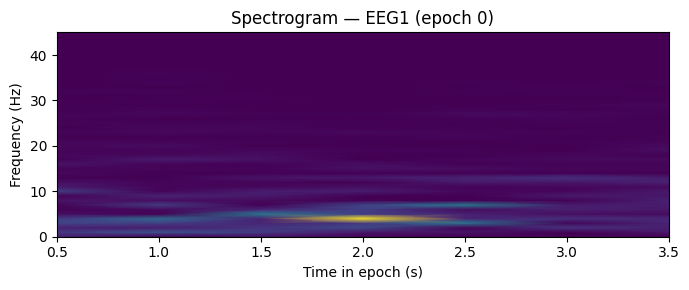

In [ ]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt


sfreq = epochs_small.info["sfreq"]
pick = mne.pick_types(epochs_small.info, eeg=True)[0]   # first EEG channel
x = epochs_small.get_data(picks=[pick])[:, 0, :]        # (n_epochs, n_times)

nperseg = int(round(1.0 * sfreq))
noverlap = int(round(0.5 * sfreq))
f, t, Sxx = spectrogram(x[0], fs=sfreq, nperseg=nperseg, noverlap=noverlap,
                        detrend=False, scaling="density", mode="psd")

plt.figure(figsize=(7, 3))
plt.pcolormesh(t, f, Sxx, shading="gouraud")
plt.ylabel("Frequency (Hz)"); plt.xlabel("Time in epoch (s)")
plt.title(f"Spectrogram — {epochs_small.ch_names[pick]} (epoch 0)")
plt.ylim(0, 45); plt.tight_layout(); plt.show()

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


C:\Users\MDBI\AppData\Local\Temp\ipykernel_16604\1583088602.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_win.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
c:\Users\MDBI\AppData\Local\miniforge3\envs\eeg-data-env\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


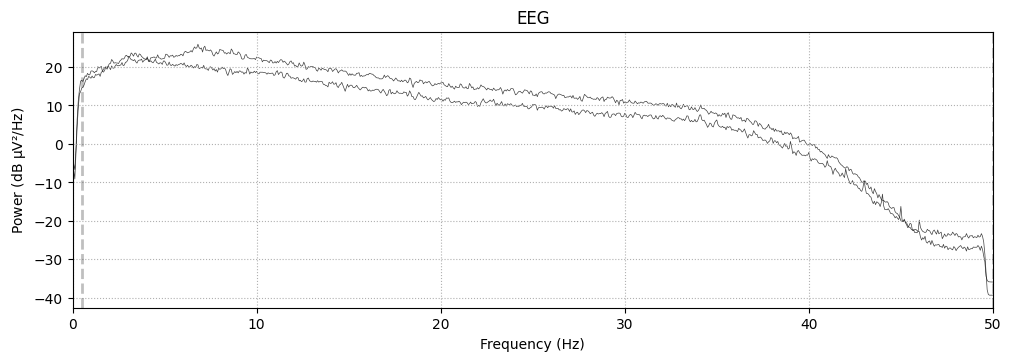

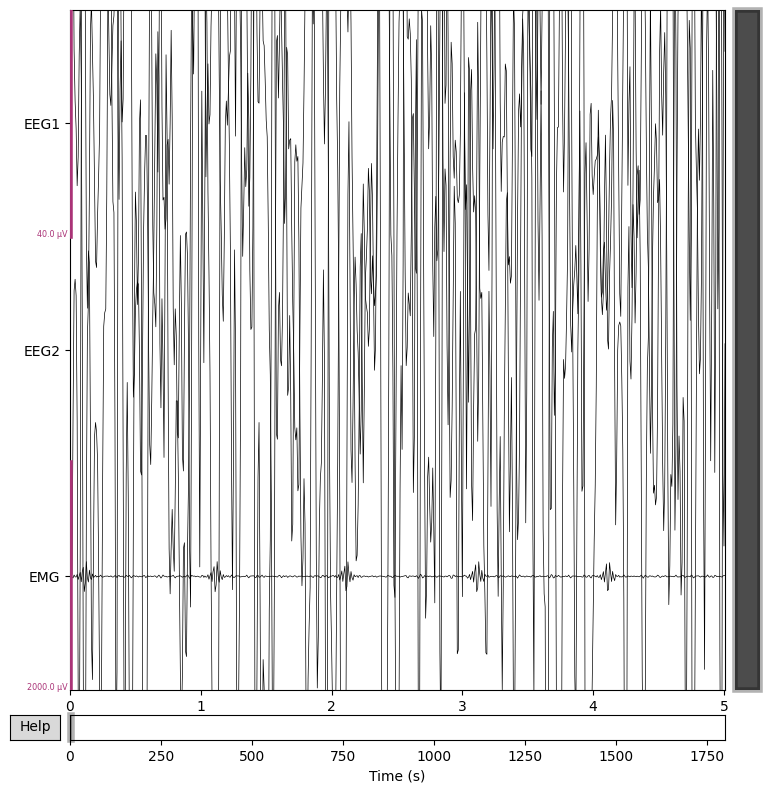

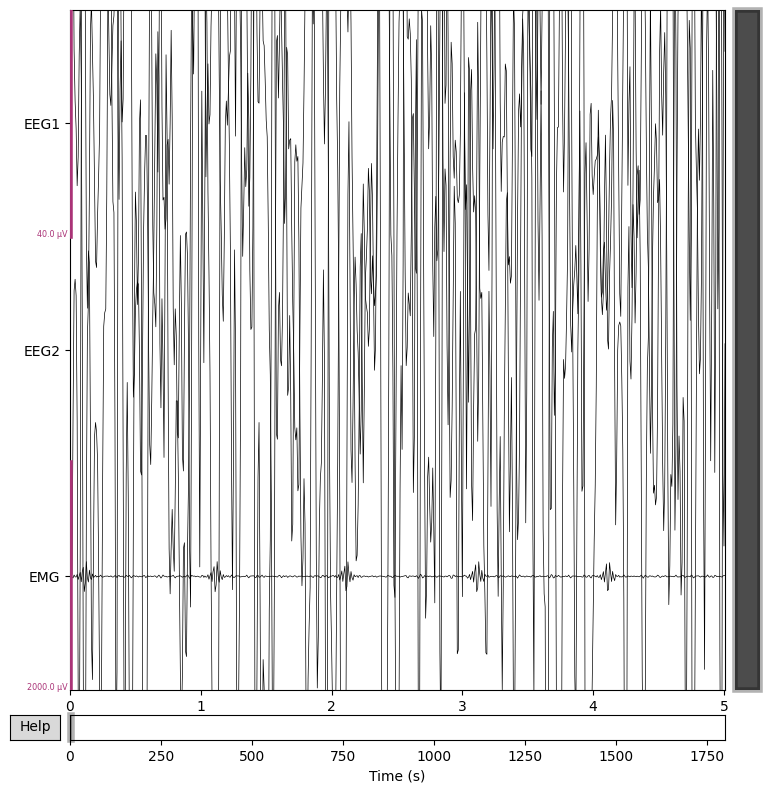

In [16]:
raw_win.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw_win.plot(duration=5, n_channels=30)

## 2. Scipy version

### 2.1 Load recordings

In [2]:
import pyedflib

manifest = pd.read_csv("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/manifest.csv")      # or use your in-memory df
row = manifest.iloc[0]
edf_path = row['edf_path']
scoring_path = row['scoring_path']

with pyedflib.EdfReader(edf_path) as f:
    n = f.signals_in_file
    ch_names = f.getSignalLabels()
    fs_list = np.array([f.getSampleFrequency(i) for i in range(n)], dtype=float)
    signals = [f.readSignal(i).astype(float) for i in range(n)]


x = signals[0]
fs = fs_list[0]

In [3]:
x.shape, n, ch_names, fs_list

((11059200,), 3, ['EEG1', 'EEG2', 'EMG'], array([128., 128., 128.]))

In [4]:
x.shape[0]/(fs*4)

np.float64(21600.0)

### Filter signal (denoise)

In [5]:
from scipy.signal import iirnotch, butter, filtfilt, spectrogram

def bandpass_filtfilt(x, fs, f_lo=0.5, f_hi=45.0, order=4):
    """Zero-phase Butterworth bandpass."""
    b, a = butter(order, [f_lo/(fs/2.0), f_hi/(fs/2.0)], btype="bandpass")
    return filtfilt(b, a, x)

In [6]:
x_filtered = bandpass_filtfilt(x, fs, f_lo=0.5, f_hi=45.0, order=4)
x_filtered.shape

(11059200,)

### Make epochs (4s)

In [7]:
import numpy as np

def make_epochs_1d(x, fs, epoch_len_s=4.0, start_s=0.0, return_starts=True):
    x = np.asarray(x)
    sp_epoch  = int(round(epoch_len_s * fs))          # samples per epoch
    start_idx = int(round(start_s * fs))              # align to scorer grid
    stop_idx  = start_idx + ((len(x) - start_idx) // sp_epoch) * sp_epoch
    x_seg = x[start_idx:stop_idx]                     # exact multiple of sp_epoch
    epochs = x_seg.reshape(-1, sp_epoch)              # (n_epochs, sp_epoch)
    if return_starts:
        starts = start_idx + np.arange(len(epochs)) * sp_epoch
        return epochs, sp_epoch, len(epochs), starts
    return epochs, sp_epoch, len(epochs)

In [8]:
epochs_eeg, sp_epoch, n_epochs, starts = make_epochs_1d(x_filtered, fs, epoch_len_s=4.0, start_s=0.0)
print(epochs_eeg.shape)   # (21600, 512)  <- expected
print(epochs_eeg.size, x.size)  # equal (just reshaped)

(21600, 512)
11059200 11059200


### Frequeny analysis of an epoch

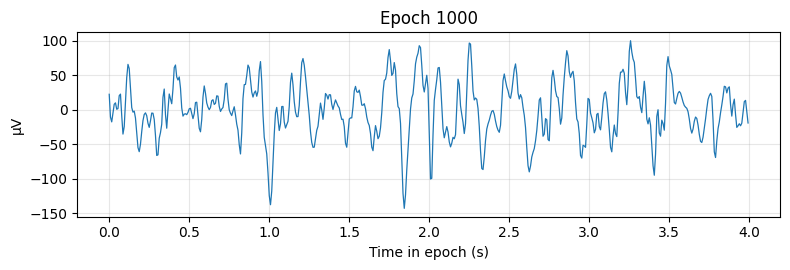

In [9]:
def plot_epoch(epoch, fs, title=None):
    t = np.arange(len(epoch)) / fs
    plt.figure(figsize=(8, 2.8))
    plt.plot(t, epoch, lw=0.9)
    plt.xlabel("Time in epoch (s)"); plt.ylabel("µV")
    if title: plt.title(title)
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Example for epoch i
i = 1000
plot_epoch(epochs_eeg[i], fs, title=f"Epoch {i}")

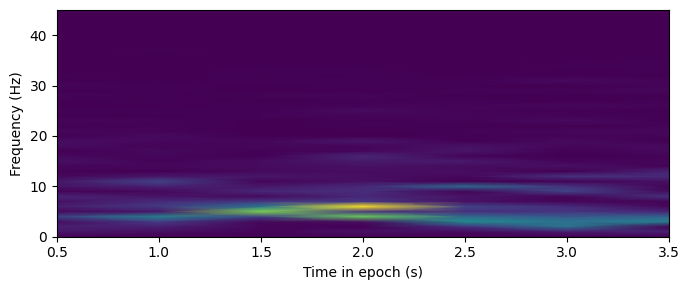

In [10]:
# Spectrogram of epoch 0
from scipy.signal import spectrogram
f, t, Sxx = spectrogram(epochs_eeg[i], fs=fs, nperseg=int(fs*1.0), noverlap=int(fs*0.5),
                        detrend=False, scaling="density", mode="psd")

plt.figure(figsize=(7, 3))
plt.pcolormesh(t, f, Sxx, shading="gouraud")
plt.ylabel("Frequency (Hz)"); plt.xlabel("Time in epoch (s)")
plt.ylim(0, 45); plt.tight_layout(); plt.show()

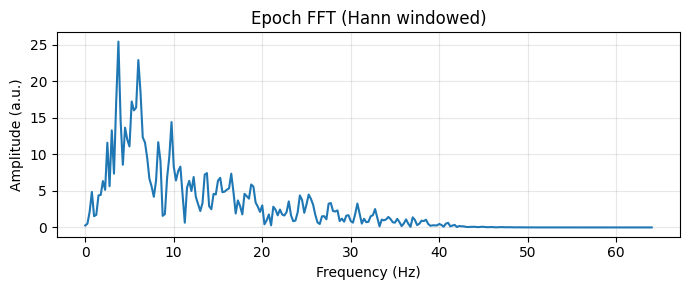

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq


y = np.asarray(epochs_eeg[i], float)
y = y - y.mean()                     # remove DC
N = y.size
T = 1.0 / fs

# Window to reduce leakage (Hann) + amplitude correction
w = np.hanning(N)
y_win = y * w
Y = rfft(y_win)
f = rfftfreq(N, T)                   # positive freqs

# Amplitude spectrum (one-sided). Correct for window loss.
U = w.mean()                         # amplitude loss factor of Hann window
amp = (2.0 / (N * U)) * np.abs(Y)    # amplitude per Hz bin (not PSD)

plt.figure(figsize=(7, 3))
plt.plot(f, amp)
plt.ylabel("Amplitude (a.u.)")
plt.xlabel("Frequency (Hz)")
plt.title("Epoch FFT (Hann windowed)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Scoring pre-processing

### 3.1 Scoring consensus

In [12]:
# Stage / artifact handling
STAGE_MAP = {"w":"Wake", "n":"NREM", "r":"REM", "W":"Wake", "N":"NREM", "R":"REM"}
ART = {"1","2","3"}
PRIORITY = {"REM": 3, "NREM": 2, "Wake": 1}


def norm_stage(x): return STAGE_MAP.get(str(x).strip(), "Unknown")

def is_artifact(a, b): return (str(a).strip() in ART) or (str(b).strip() in ART)

def consensus(a, b, consensus_rule="priority"):
    if is_artifact(a, b): return "Artifact"
    a, b = norm_stage(a), norm_stage(b)
    if consensus_rule == "agree": return a if a == b else "Unknown"
    if a == b: return a
    if a in PRIORITY and b in PRIORITY: return a if PRIORITY[a] >= PRIORITY[b] else b
    return "Unknown"

consensus_rule = "priority"  # or "agree"
sc = pd.read_csv(scoring_path, header=None, names=["epoch", "s1", "s2"], sep=r"[;,]", engine="python")
sc["s1"] = sc["s1"].astype(str).str.strip()
sc["s2"] = sc["s2"].astype(str).str.strip()

# Stage / artifact handling
sc["stage"] = [consensus(a, b, consensus_rule) for a, b in zip(sc["s1"], sc["s2"])]
sc["artifact"] = [is_artifact(a, b) for a, b in zip(sc["s1"], sc["s2"])]

sc.head()

,epoch,s1,s2,stage,artifact
0,0,n,n,NREM,False
1,1,n,n,NREM,False
2,2,n,n,NREM,False
3,3,n,n,NREM,False
4,4,n,n,NREM,False


## 3. EEG-signal and sleep stages

I want to plot:
1. Histogram for each vigilance state
2. Frequency decomposition (FFT) for each vigilance state
3. Spectrogram for each vigilance state (FFT vs multi-taper)

In [13]:
artifact_mask = sc.artifact == True

epochs_eeg_clean = epochs_eeg[~artifact_mask.values]
sc_clean = sc[~artifact_mask]

In [14]:
wake_mask = sc_clean.stage == "Wake"
nrem_mask = sc_clean.stage == "NREM"
rem_mask = sc_clean.stage == "REM"

rem_eeg = epochs_eeg_clean[rem_mask.values]
nrem_eeg = epochs_eeg_clean[nrem_mask.values]
wake_eeg = epochs_eeg_clean[wake_mask.values]

print(rem_eeg.shape, nrem_eeg.shape, wake_eeg.shape)

(1565, 512) (7808, 512) (10559, 512)


C:\Users\MDBI\AppData\Local\Temp\ipykernel_43624\1838899691.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(mean_psd, freqs)
C:\Users\MDBI\AppData\Local\Temp\ipykernel_43624\1838899691.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bin_power.append(np.trapz(mean_psd[m], freqs[m]))


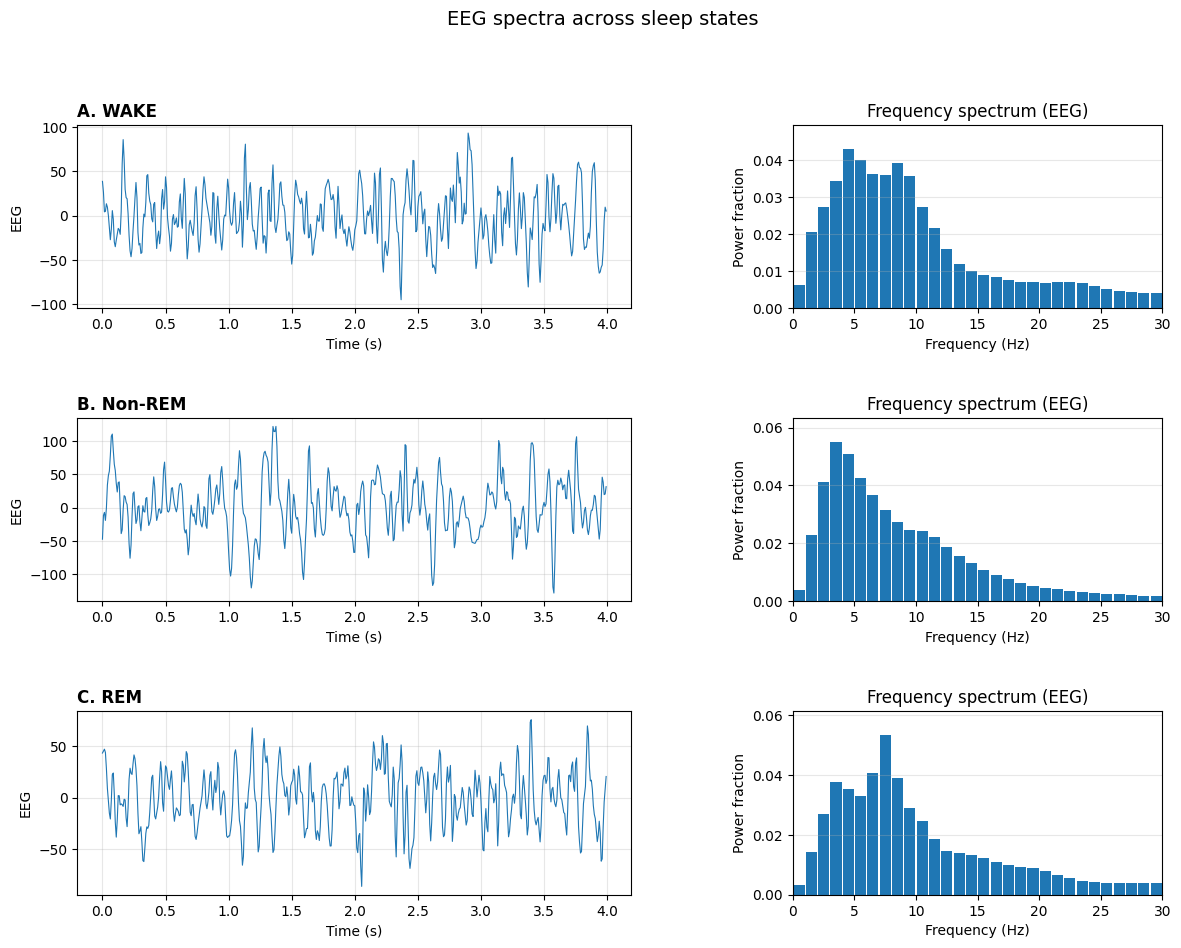

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# -------------------- helpers --------------------

def psd_welch_epochs(epochs, fs, nperseg=None, noverlap=None, window='hann'):
    """Welch PSD for each epoch (epochs: [n_epochs, n_samples])."""
    epochs = np.asarray(epochs)
    assert epochs.ndim == 2, "epochs must be 2D: (n_epochs, n_samples)"
    n_epochs, n_samples = epochs.shape
    if nperseg is None:
        nperseg = min(256, n_samples)
    if noverlap is None:
        noverlap = nperseg // 2
    f, psd = welch(
        epochs, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
        detrend='constant', return_onesided=True, scaling='density', axis=1, average='mean'
    )
    return f, psd  # psd shape: (n_epochs, n_freqs)

def representative_epoch_idx(epochs):
    """Pick an epoch near the median power to avoid outliers."""
    pow_per_epoch = (epochs**2).mean(axis=1)
    return np.argsort(pow_per_epoch)[len(pow_per_epoch)//2]

def binned_psd_fraction(freqs, mean_psd, max_freq=30.0, bin_width=1.0):
    """Integrate PSD into bins and return fraction of total power per bin."""
    freqs = np.asarray(freqs)
    mean_psd = np.asarray(mean_psd)
    mask = (freqs >= 0) & (freqs <= min(max_freq, freqs.max()))
    freqs = freqs[mask]
    mean_psd = mean_psd[mask]

    total_power = np.trapz(mean_psd, freqs)
    edges = np.arange(0, min(max_freq, freqs.max()) + bin_width, bin_width)
    bin_power = []
    for lo, hi in zip(edges[:-1], edges[1:]):
        m = (freqs >= lo) & (freqs < hi)
        if not np.any(m):
            bin_power.append(0.0)
        else:
            bin_power.append(np.trapz(mean_psd[m], freqs[m]))
    bin_power = np.asarray(bin_power)
    frac = bin_power / total_power if total_power > 0 else bin_power
    centers = (edges[:-1] + edges[1:]) / 2.0
    return centers, frac, edges

# -------------------- main plotting --------------------

def plot_sleep_states(
    wake_eeg, nrem_eeg, rem_eeg, fs,
    wake_emg=None, nrem_emg=None, rem_emg=None,
    max_freq=30.0, bin_width=1.0
):
    """
    Each *_eeg is (n_epochs, n_samples). *_emg optional with same shape.
    """
    states = [
        ("A. WAKE", wake_eeg, wake_emg),
        ("B. Non-REM", nrem_eeg, nrem_emg),
        ("C. REM", rem_eeg, rem_emg),
    ]

    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 2, width_ratios=[3, 2], hspace=0.6, wspace=0.35)

    for r, (title, eeg_epochs, emg_epochs) in enumerate(states):
        # --- compute PSD across epochs ---
        freqs, psd_epochs = psd_welch_epochs(eeg_epochs, fs)
        mean_psd = psd_epochs.mean(axis=0)

        centers, frac, edges = binned_psd_fraction(freqs, mean_psd,
                                                   max_freq=max_freq, bin_width=bin_width)

        # --- choose a representative epoch to show (EEG/EMG) ---
        idx = representative_epoch_idx(eeg_epochs)
        eeg_rep = eeg_epochs[idx]
        t = np.arange(eeg_rep.size) / fs

        # left cell: make 1 or 2 stacked axes depending on EMG
        left_spec = GridSpecFromSubplotSpec(2 if emg_epochs is not None else 1, 1,
                                            subplot_spec=gs[r, 0], hspace=0.1)
        ax_eeg = fig.add_subplot(left_spec[0, 0])
        ax_eeg.plot(t, eeg_rep, lw=0.8)
        ax_eeg.set_ylabel('EEG')
        ax_eeg.set_title(title, loc='left', fontweight='bold')
        ax_eeg.grid(True, alpha=0.3)
        if emg_epochs is not None:
            emg_rep = emg_epochs[idx]
            ax_emg = fig.add_subplot(left_spec[1, 0], sharex=ax_eeg)
            ax_emg.plot(t, emg_rep, lw=0.8)
            ax_emg.set_ylabel('EMG')
            ax_emg.grid(True, alpha=0.3)
            ax_emg.set_xlabel('Time (s)')
            plt.setp(ax_eeg.get_xticklabels(), visible=False)
        else:
            ax_eeg.set_xlabel('Time (s)')

        # right cell: binned frequency spectrum as bars
        ax_bar = fig.add_subplot(gs[r, 1])
        ax_bar.bar(centers, frac, width=bin_width*0.9, align='center')
        ax_bar.set_xlim(0, max_freq)
        ax_bar.set_ylim(0, max(0.001, frac.max()*1.15))
        ax_bar.set_xlabel('Frequency (Hz)')
        ax_bar.set_ylabel('Power fraction')
        ax_bar.set_title('Frequency spectrum (EEG)')
        ax_bar.grid(True, axis='y', alpha=0.3)

    fig.suptitle('EEG spectra across sleep states', y=0.995, fontsize=14)
    plt.show()

# -------------------- usage --------------------
# Replace these with your arrays. Shapes: (n_epochs, n_samples) e.g. (1500, 512)
# 
fs = 128  # Hz  <-- set to your sampling rate!
plot_sleep_states(wake_eeg, nrem_eeg, rem_eeg, fs=fs)

# Example call (with EMG too, optional):
# plot_sleep_states(wake_eeg, nrem_eeg, rem_eeg, fs=fs,
#                   wake_emg=wake_emg, nrem_emg=nrem_emg, rem_emg=rem_emg)


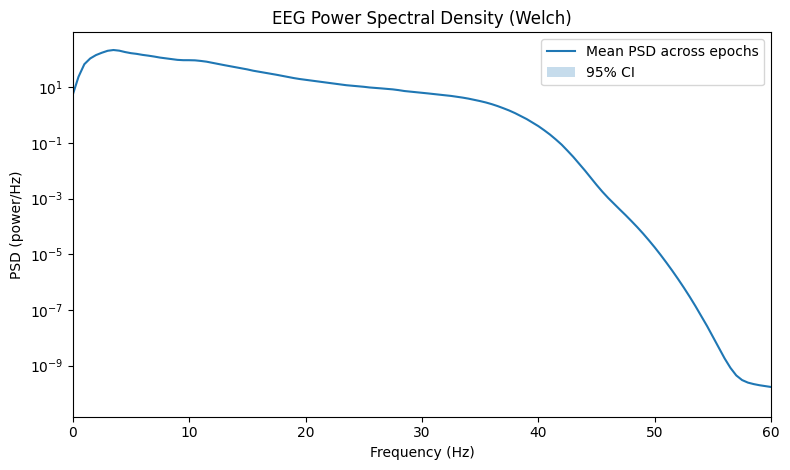

C:\Users\MDBI\AppData\Local\Temp\ipykernel_43624\3726049142.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_powers[name] = np.trapz(mean_psd[idx], freqs[idx])  # integrates PSD -> band power


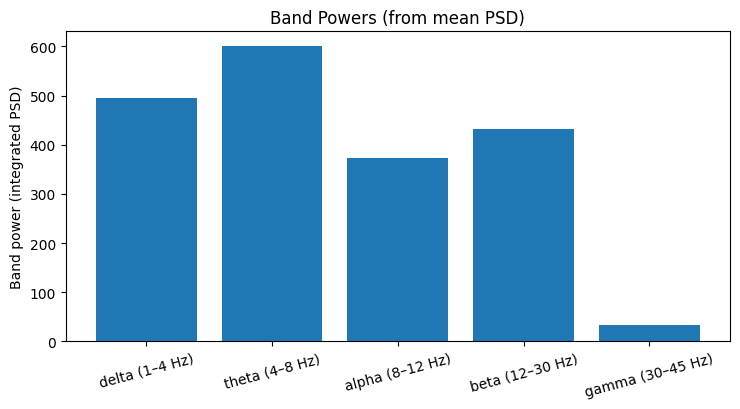

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# ---- inputs ----
# eeg: shape (n_epochs, n_samples_per_epoch)
# Example placeholder:
# eeg = np.random.randn(1500, 512) * 1e-6  # 1500 epochs, 512 samples each, ~microvolt-scale
eeg = nrem_eeg  # <- replace with your array variable

fs = 128.0  # <-- IMPORTANT: set to your true sampling rate in Hz

# ---- PSD via Welch ----
def psd_welch_epochs(eeg_epochs, fs, nperseg=None, noverlap=None, window='hann', detrend='constant'):
    """
    eeg_epochs: array (n_epochs, n_samples)
    returns: freqs (F,), psd_epochs (n_epochs, F)
    """
    eeg_epochs = np.asarray(eeg_epochs)
    assert eeg_epochs.ndim == 2, "Expected (n_epochs, n_samples)"
    n_epochs, n_samp = eeg_epochs.shape

    if nperseg is None:
        nperseg = min(256, n_samp)  # reasonable default for 512-sample epochs
    nperseg = max(32, min(nperseg, n_samp))  # clamp

    if noverlap is None:
        noverlap = nperseg // 2

    # Welch handles batch along axis=1
    freqs, psd = welch(
        eeg_epochs,
        fs=fs,
        window=window,
        nperseg=nperseg,
        noverlap=noverlap,
        detrend=detrend,
        return_onesided=True,
        scaling='density',
        axis=1,
        average='mean',  # average segments within each epoch
    )
    # psd shape: (n_epochs, n_freqs)
    return freqs, psd

freqs, psd_epochs = psd_welch_epochs(eeg, fs)

# ---- average across epochs + 95% CI ----
mean_psd = psd_epochs.mean(axis=0)
sem_psd  = psd_epochs.std(axis=0, ddof=1) / np.sqrt(psd_epochs.shape[0])
ci95     = 1.96 * sem_psd
lower = np.maximum(mean_psd - ci95, 1e-30)
upper = mean_psd + ci95

# ---- plot average spectrum ----
plt.figure(figsize=(8, 4.8))
plt.semilogy(freqs, mean_psd, label='Mean PSD across epochs')
plt.fill_between(freqs, lower, upper, alpha=0.25, label='95% CI')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (power/Hz)')
plt.title('EEG Power Spectral Density (Welch)')
plt.xlim(0, min(60, freqs.max()))  # show up to 60 Hz by default; adjust as needed
plt.legend()
plt.tight_layout()
plt.show()

# ---- compute band powers from the MEAN PSD ----
# Adjust bands to your needs and Nyquist
nyq = freqs.max()
bands = {
    'delta (1–4 Hz)':  (1.0, min(4.0, nyq)),
    'theta (4–8 Hz)':  (4.0, min(8.0, nyq)),
    'alpha (8–12 Hz)': (8.0, min(12.0, nyq)),
    'beta (12–30 Hz)': (12.0, min(30.0, nyq)),
    'gamma (30–45 Hz)': (30.0, min(45.0, nyq)),
}
band_powers = {}
for name, (f_lo, f_hi) in bands.items():
    if f_lo >= f_hi:
        band_powers[name] = np.nan
        continue
    idx = (freqs >= f_lo) & (freqs <= f_hi)
    band_powers[name] = np.trapz(mean_psd[idx], freqs[idx])  # integrates PSD -> band power

# ---- plot band powers ----
labels = list(band_powers.keys())
values = [band_powers[k] for k in labels]

plt.figure(figsize=(7.5, 4.2))
plt.bar(labels, values)
plt.ylabel('Band power (integrated PSD)')
plt.title('Band Powers (from mean PSD)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()